# Santander Customer Transaction Prediction
At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.

Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?

In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.

**Note**:
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

### EDA and Simple Modeling

Before digging deep into the modeling aspect, I'd like to spend some time on this data set, and see if there is anything that might help in solving this particular problem. One of the very first things that is apparent is how imbalanced the data set is. Majority of the observations are negative (class 0), which suggests that the models should "pay more attention" to the positive samples (i.e. assign higher weights for the positive class). There is little I can infer from the correlation matrix, apart from the fact that none of the features are highly correlated with each other, which means that most of them (if not all) are important. If there were any features that would be redundant, there could be a possibility of performing PCA to reduce the dimensionality of the dataset.

**What about feature engineering?**

It would be very hard to perform feature engineering of any kind. All of these features are labeled in a way that nothing really can be infered/assumed. The only possibility that I see so far is to perform something called "Machine Learning EDA" and just see what the model (Random Forest for example) will output as important features, and then based on that perform some feature engineering.

Before any modeling, setting the hyperparameters, and all the "good stuff", let's read in the libraries used in this project.

**Note:** This notebook contains modeling performed using sklearn's models. However, my aim for this project is to also use PyTorch, and maybe somewhere down the line some unsupervised algorithms. But I am very interested what would be the output of some kind of a deep learning model (or a combination thereof).

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Random Forest
from sklearn.ensemble import RandomForestClassifier
import xgboost

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve

# Sklearn Model Selection 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

In [2]:
data_path = os.getcwd() + '/data'

In [16]:
train = pd.read_csv(data_path + '/train.csv')

In [17]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [18]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [19]:
distincts = train.apply(lambda x: len(x.unique()))

In [20]:
distincts

ID_code    200000
target          2
var_0       94672
var_1      108932
var_2       86555
            ...  
var_195     57870
var_196    125560
var_197     40537
var_198     94153
var_199    149430
Length: 202, dtype: int64

Scaling the data makes sense if I was to use logistic regression to solve this problem. For Random Forests it makes no difference. Another classifier that we might take into consideration is SGDClassifier. Certainly XGBoost will be used further down the line.

In [41]:
def corr_sort(df):
    correlation_matrix = df.corr()
    corr_matrix_unstacked = correlation_matrix.unstack()
    
    sortedvalues = corr_matrix_unstacked.sort_values(kind = 'quicksort')
    
    return pd.DataFrame(data = sortedvalues[sortedvalues < 1.0], columns= ['Pearson correlation'])

In [42]:
corr_sort(train)

Pearson correlation
target  var_81             -0.080917
var_81  target             -0.080917
var_139 target             -0.074080
target  var_139            -0.074080
        var_12             -0.069489
...                              ...
        var_53              0.063399
        var_110             0.064275
var_110 target              0.064275
var_6   target              0.066731
target  var_6               0.066731

[40200 rows x 1 columns]

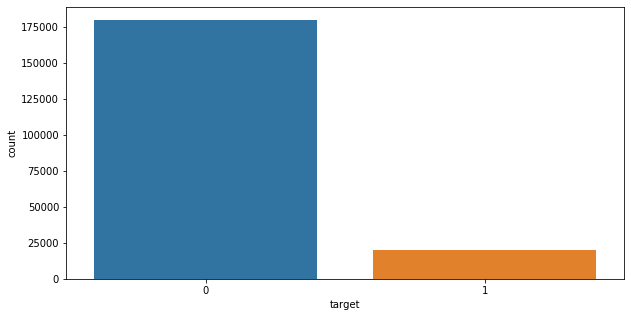

In [23]:
plt.figure(figsize = (10,5))
sns.countplot(train.target)

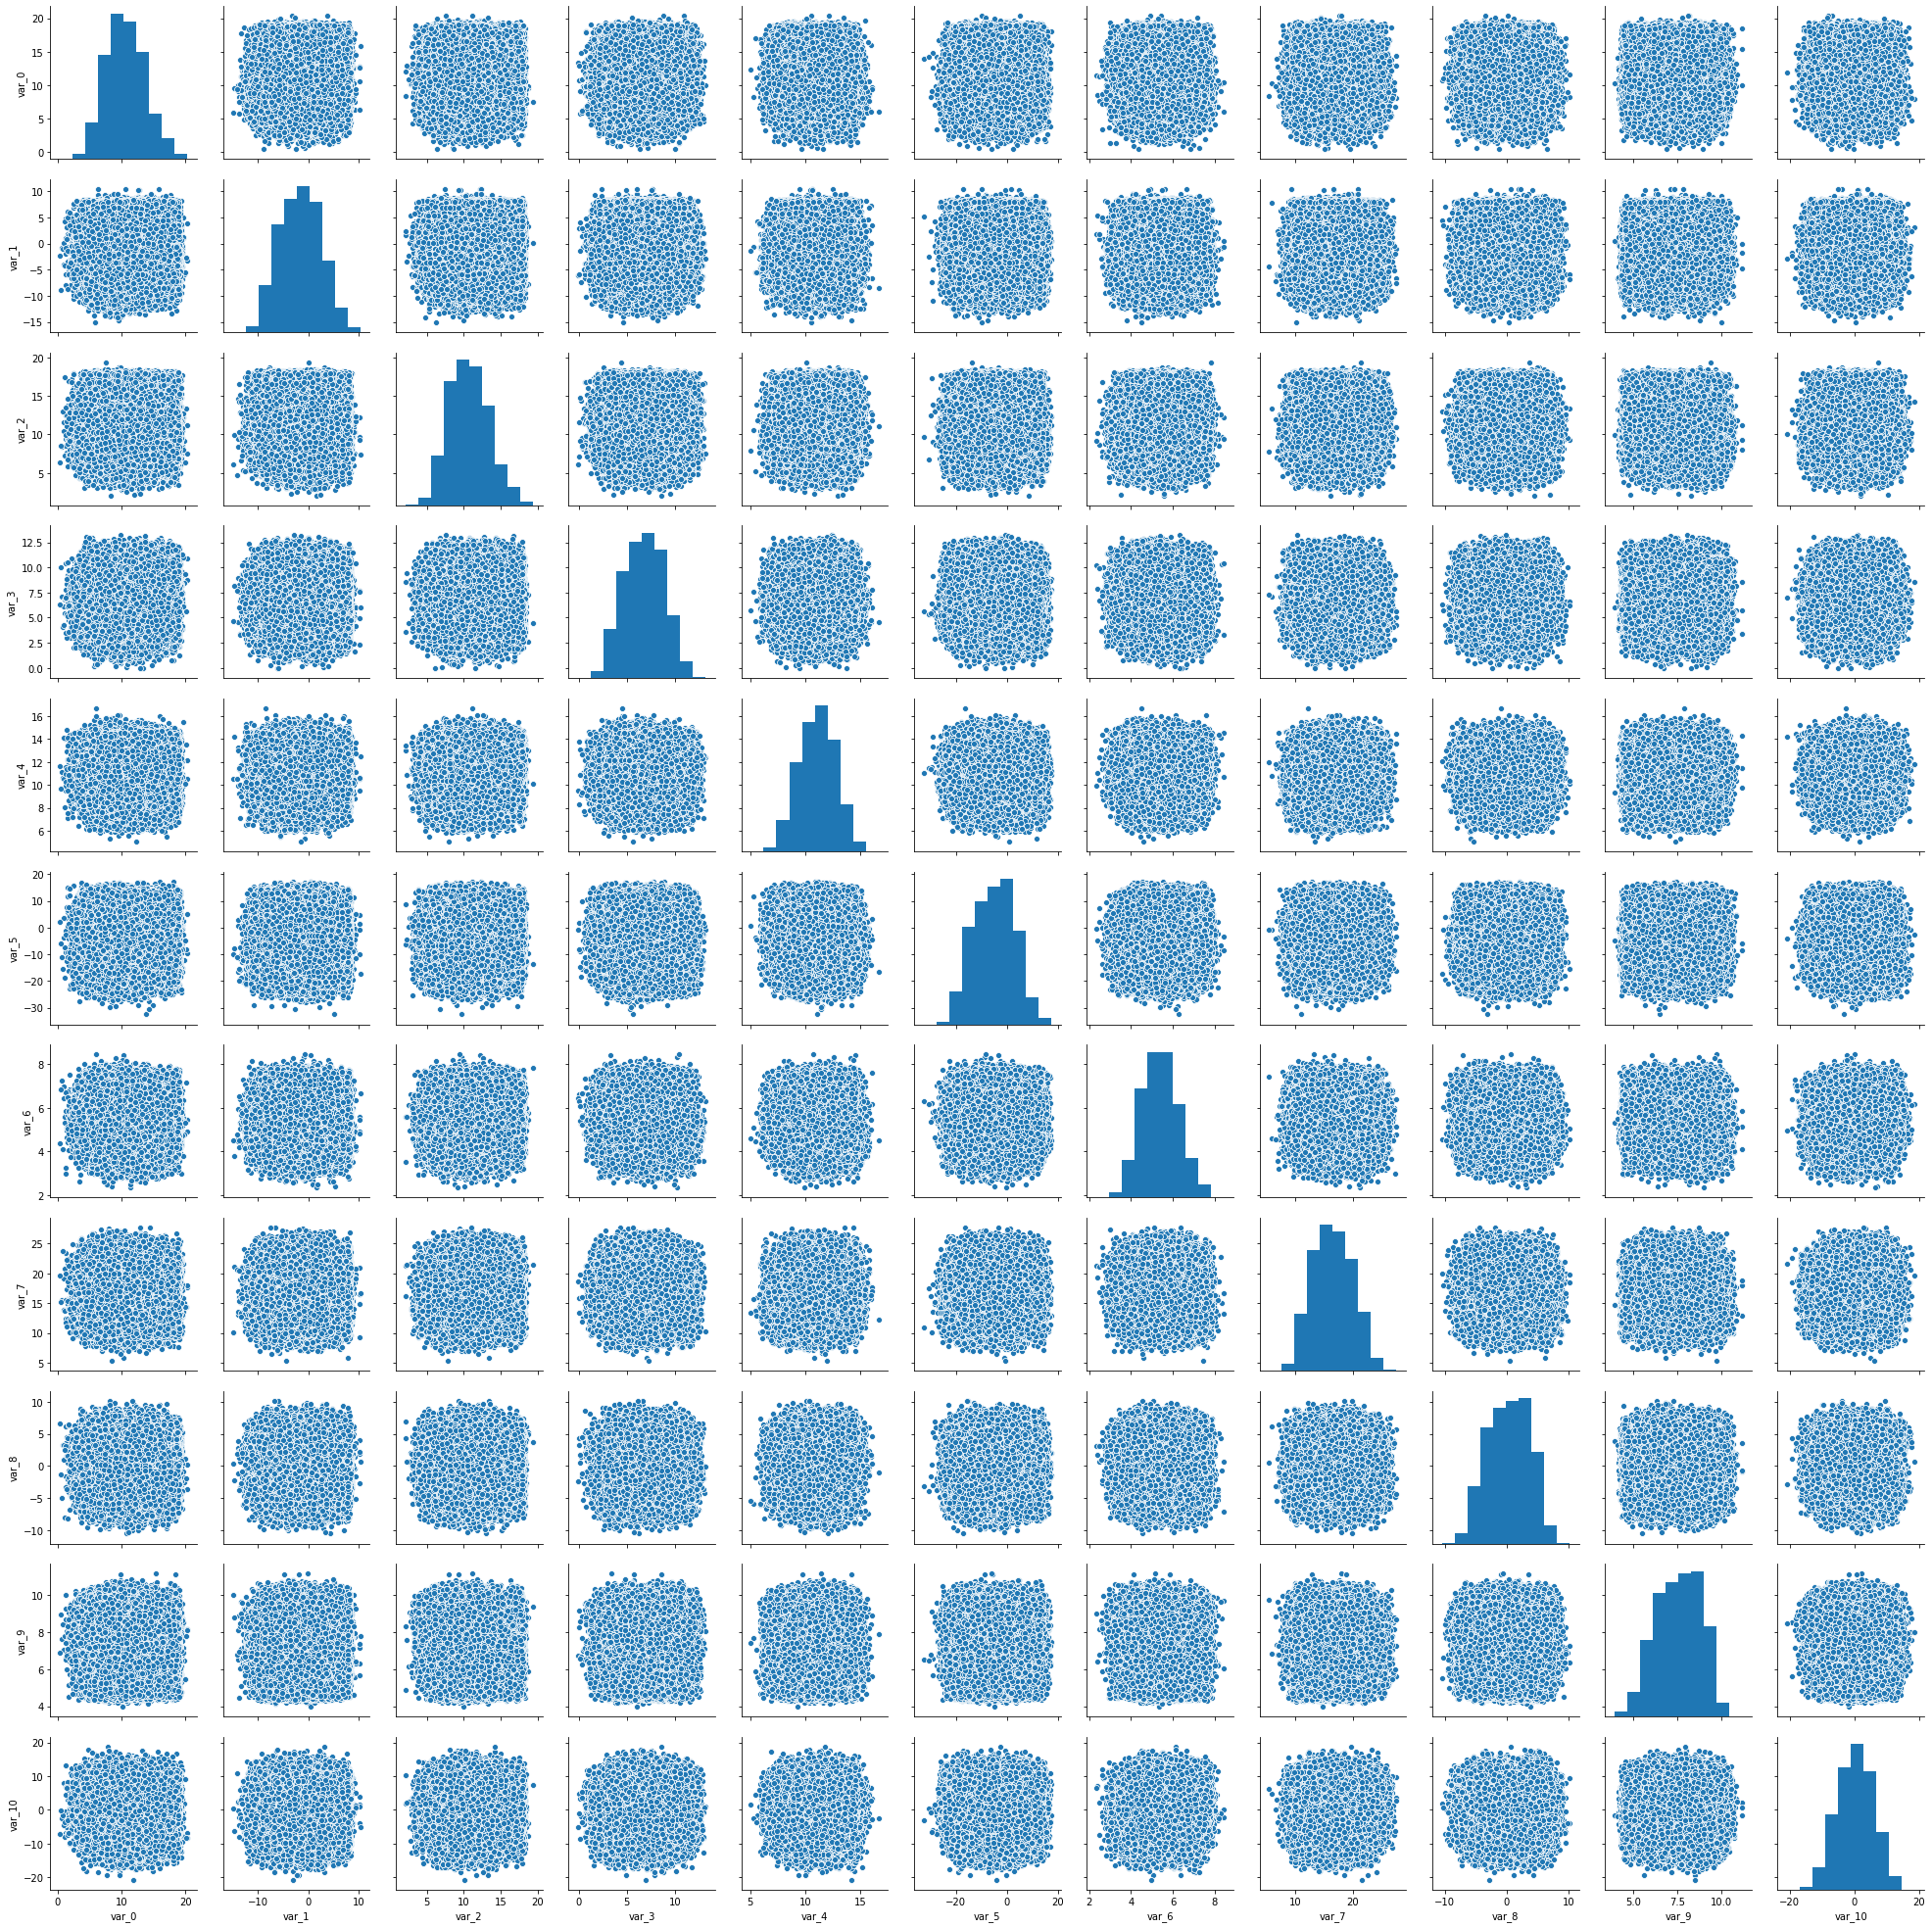

In [45]:
subset = ['var_0','var_1', 'var_2', 
          'var_3', 'var_4', 'var_5', 
          'var_6', 'var_7', 'var_8',
         'var_9', 'var_10']
sns.pairplot(X[subset])

In [24]:
print('Ratio of negative class to the whole dataset:', len(train[train['target']==0]) / len(train))
print('Ratio of positive class to the whole dataset:', len(train[train['target']==1]) / len(train))

Ratio of negative class to the whole dataset: 0.89951
Ratio of positive class to the whole dataset: 0.10049


This indicates that we should stratify the target variable, because the dataset is highly imbalanced.

In [25]:
ID_code = train['ID_code']
X = train.drop(['ID_code', 'target'], axis = 1)
y = train['target']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y)

In [27]:
forest_clf = RandomForestClassifier(random_state = 42, 
                                    n_jobs = -1, 
                                    max_depth=10, 
                                    n_estimators=10, class_weight= 'balanced')

In [28]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [29]:
cross_val_score(forest_clf, 
                X_train, 
                y_train, 
                cv = 5, 
                n_jobs = -1, 
                scoring = 'accuracy')

array([0.82765568, 0.82496269, 0.83179104, 0.82656716, 0.82357551])

The results from the CV look okay. Accuracy is about 82/83% on the Cross Validation. I, for one, am suspicious of these high scores on the CV. Let's dig deeper and see the ROC curve for that model. In order to visualize this we have to use the cross_val_predict to calculate class probabilities (Random Forest does not have the decision_function() method, therefore we have to use the predict proba method, and then use the column with calculated probabilities for the positive class), and then plug in the results to precision_recall_score function from sklearn.

In [30]:
y_probas_rf = cross_val_predict(forest_clf, 
                                X_train, 
                                y_train, 
                                cv = 5, 
                                method = 'predict_proba', 
                                n_jobs=-1)

In [31]:
y_scores_rf = y_probas_rf[:, 1]

In [32]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores_rf)

In [33]:
def plot_ROC(fpr, tpr, thresholds, actuals, scores,  model = None):
    plt.figure(figsize = (10,5))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], 'k--')
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('ROC curve for ' + str(model))
    
    print('Area Under the Curve score:', roc_auc_score(actuals, scores))

Area Under the Curve score: 0.7085138376415159


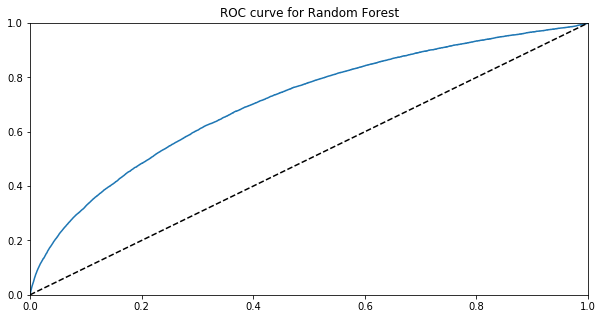

In [34]:
plot_ROC(fpr, tpr, thresholds, 
         model = 'Random Forest', 
         actuals=y_train, 
         scores=y_scores_rf)

Even though the Cross Validation scores were looking good; the ROC curve shows that the model is not performing that well. The area under the curve is 70%. Definitely there is a room for improvement here!

In [35]:
y_train_preds = cross_val_predict(forest_clf, 
                                  X_train, 
                                  y_train, 
                                  n_jobs = -1)

/Users/januszpolowczyk/Documents/Santander/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [36]:
precision_score(y_train, y_train_preds)

0.24363976042639707

In [37]:
recall_score(y_train, y_train_preds)

0.3292737264221001

The scores above strengthen the intuition that the model is not performing well. The precision is 24%, which means that the model correctly classifies customers that will make a specific transaction only 24% of the time. The recall score means that the model "caught" only 32% of the specific transactions performed by the customers. 

In [38]:
y_probas_rf[:, 1]

array([0.54534457, 0.52309787, 0.28711803, ..., 0.44942691, 0.51366006,
       0.35444143])